In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.distributions import MultivariateNormal as MNormal
from torch.distributions import Normal, Categorical
from matplotlib import pyplot as plt

from samplers_new import mala, i_sir, ex2_mcmc, flex2_mcmc, flex2_mcmc_imh, RealNVPProposal
import tqdm

In [2]:
def target_dens(x):
    """
    returns the value of a target density - mixture of the 3 gaussians 
    """
    return np.exp(-np.sum((x-mu[0])**2)/(2*sigma**2)) + np.exp(-np.sum((x-mu[1])**2)/(2*sigma**2)) +\
                 np.exp(-np.sum((x-mu[2])**2)/(2*sigma**2))

def grad_target_dens(x):
    """
    returns the gradient of log-density 
    """
    lin_x = np.zeros(3,dtype = float)
    exp_x = np.zeros(3,dtype = float)
    for i in range(3):
        exp_x[i] = np.exp(-np.sum((x-mu[i])**2)/(2*sigma**2))
    grad = np.zeros(2,dtype=float)
    for i in range(3):
        grad -= exp_x[i]*(x-mu[i])/sigma**2
    return grad/target_dens(x)

def logp_mala(y,z,gamma):
    return -1/(4*gamma)*(np.sum((y - z - gamma*grad_target_dens(z))**2))

def discretesampling(w):
    u = np.random.rand()
    bins = np.cumsum(w)
    return np.digitize(u,bins)

def log_dens_isir(x,sigma):
    """
    compute log-density of a normal distributio nwith standard deviation sigma**2
    """
    return -np.sum(x**2)/(2*sigma**2)

### Put parameters of the target density

In [3]:
#method to compute log probability
def log_prob(x: torch.FloatTensor, detach = False) -> torch.FloatTensor:
        """
        Returns:
            log p(x)
        """
        log_ps = torch.stack([
            torch.log(weight) + gauss.log_prob(x) for weight, gauss in zip(weights, gaussians)
            ], dim=0)
        return torch.logsumexp(log_ps, dim=0)

In [4]:
#initialize starting points for the distribution
seed = 42
torch.manual_seed(42)
device = 'cpu'

#initialize dimension
dim = 100
#init scaling parameter for the density
a = 4.0
#standard deviations for the cluster centers
sigma = 1.0

#initialize centers of the clusters
center_pts = (np.random.rand(3,dim)-0.5)

locs = a*torch.FloatTensor([center_pts[0,0:(dim-2)].tolist() + [0.0, 1.0], \
                          center_pts[1,0:(dim-2)].tolist() + [np.sqrt(3)/2,-0.5], \
                          center_pts[2,0:(dim-2)].tolist()+ [-np.sqrt(3)/2,-0.5]])
covs = sigma*torch.eye(dim)[None, ...].repeat(3, 1, 1).float()
#normalized weights of the mixture
weights = torch.FloatTensor([1, 1, 1])
weights /= weights.sum()
#create Gaussian densities with different centers
gaussians = [MNormal(loc, cov) for loc, cov in zip(locs, covs)]


#init number of trajectories
N_traj = 100
#init starting points 
x0 = torch.randn(N_traj, dim).to(device)

### Plot density contours

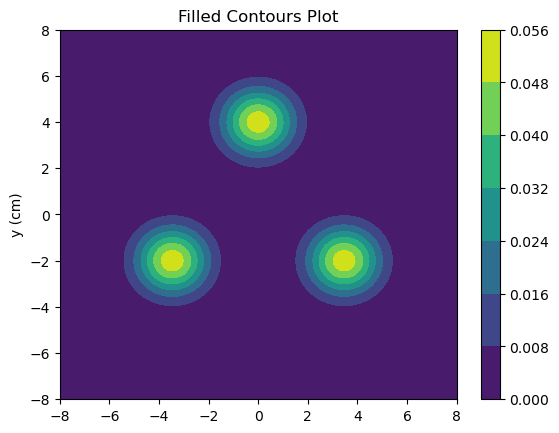

In [5]:
N_pts = 100
x = np.linspace(-2*a, 2*a, 100)
y = np.linspace(-2*a, 2*a, 100)
X, Y = np.meshgrid(x, y)
#stack the two
inp = torch.FloatTensor(np.stack([X, Y], -1))
proj_slice = [-2, -1]

#project onto the last 2 coordinates
loc_gaussians = [MNormal(loc[proj_slice], cov[proj_slice, :][:, proj_slice]) for loc, cov in zip(locs, covs)]
log_ps = torch.stack([
    torch.log(weight) + gauss.log_prob(inp.reshape(-1, 2)) for weight, gauss in zip(weights, loc_gaussians)
], dim=0)
dens_vals = torch.logsumexp(log_ps, dim=0).reshape(inp.shape[:-1])
#plot density values
fig,ax=plt.subplots(1,1)
cp = ax.contourf(X, Y, dens_vals.exp())
fig.colorbar(cp) # Add a colorbar to a plot
ax.set_title('Filled Contours Plot')
#ax.set_xlabel('x (cm)')
ax.set_ylabel('y (cm)')
plt.show()

### Sample with i-SIR algorithm

In [6]:
N_steps = 1000
N_part = 200
sigma_isir = 4.0

#choose proposal for i-SIR algorithm
isir_proposal = MNormal(
    torch.zeros(dim).to(device), (sigma_isir ** 2) * torch.eye(dim).to(device)
)

#run i-SIR
Samples_isir = i_sir(log_prob, x0, N_steps, N_part, isir_proposal, seed=42)

100%|██████████| 1000/1000 [01:37<00:00, 10.22it/s]


In [7]:
Samples_isir.shape

torch.Size([100, 1001, 100])

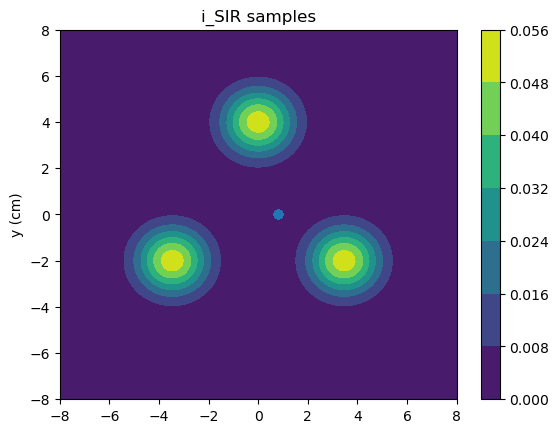

In [8]:
x = np.linspace(-2*a, 2*a, 100)
y = np.linspace(-2*a, 2*a, 100)
X, Y = np.meshgrid(x, y)
#stack the two
inp = torch.FloatTensor(np.stack([X, Y], -1))
proj_slice = [-2, -1]

#project onto the last 2 coordinates
loc_gaussians = [MNormal(loc[proj_slice], cov[proj_slice, :][:, proj_slice]) for loc, cov in zip(locs, covs)]
log_ps = torch.stack([
    torch.log(weight) + gauss.log_prob(inp.reshape(-1, 2)) for weight, gauss in zip(weights, loc_gaussians)
], dim=0)
dens_vals = torch.logsumexp(log_ps, dim=0).reshape(inp.shape[:-1])
#plot density values
fig,ax=plt.subplots(1,1)
cp = ax.contourf(X, Y, dens_vals.exp())
fig.colorbar(cp) # Add a colorbar to a plot
#plot i-sir samples
ax.scatter(Samples_isir[0,:,-2],Samples_isir[0,:,-1])
ax.set_title('i_SIR samples')
#ax.set_xlabel('x (cm)')
ax.set_ylabel('y (cm)')
plt.show()

### Sample the same mixture with MALA

In [ ]:
#MALA steps
N_steps = 1000
gamma = 0.5
N_steps_mala = 3

stats = None

#sample with MALA
Samples_mala = mala(log_prob, x0, N_steps, gamma, N_steps_mala, stats=None, seed=42)
Samples_mala.shape

In [ ]:
N_pts = 100
traj_number = 0
x = np.linspace(-2*a, 2*a, N_pts)
y = np.linspace(-2*a, 2*a, N_pts)
X, Y = np.meshgrid(x, y)
#stack the two
inp = torch.FloatTensor(np.stack([X, Y], -1))
proj_slice = [-2, -1]

#project onto the last 2 coordinates
loc_gaussians = [MNormal(loc[proj_slice], cov[proj_slice, :][:, proj_slice]) for loc, cov in zip(locs, covs)]
log_ps = torch.stack([
    torch.log(weight) + gauss.log_prob(inp.reshape(-1, 2)) for weight, gauss in zip(weights, loc_gaussians)
], dim=0)
dens_vals = torch.logsumexp(log_ps, dim=0).reshape(inp.shape[:-1])
#plot density values
fig,ax=plt.subplots(1,1)
cp = ax.contourf(X, Y, dens_vals.exp())
fig.colorbar(cp) # Add a colorbar to a plot
#plot mala samples
ax.scatter(Samples_mala[traj_number,:,-2],Samples_mala[traj_number,:,-1])
ax.set_title('MALA samples')
#ax.set_xlabel('x (cm)')
ax.set_ylabel('y (cm)')
plt.show()

### Sample the same mixture with Ex$^2$MCMC

In [ ]:
Samples_ex2 = ex2_mcmc(log_prob, x0, N_steps, N_part, isir_proposal, gamma, N_steps_mala, stats=None, seed=42)
Samples_ex2.shape

In [ ]:
traj_number = 0
x = np.linspace(-2*a, 2*a, N_pts)
y = np.linspace(-2*a, 2*a, N_pts)
X, Y = np.meshgrid(x, y)
traj_number = 1
#stack the two
inp = torch.FloatTensor(np.stack([X, Y], -1))
proj_slice = [-2, -1]

#project onto the last 2 coordinates
loc_gaussians = [MNormal(loc[proj_slice], cov[proj_slice, :][:, proj_slice]) for loc, cov in zip(locs, covs)]
log_ps = torch.stack([
    torch.log(weight) + gauss.log_prob(inp.reshape(-1, 2)) for weight, gauss in zip(weights, loc_gaussians)
], dim=0)
dens_vals = torch.logsumexp(log_ps, dim=0).reshape(inp.shape[:-1])
#plot density values
fig,ax=plt.subplots(1,1)
cp = ax.contourf(X, Y, dens_vals.exp())
fig.colorbar(cp) # Add a colorbar to a plot
#plot mala samples
ax.scatter(Samples_ex2[traj_number,:,-2],Samples_ex2[traj_number,:,-1])
ax.set_title('Ex$^2$MCMC samples')
#ax.set_xlabel('x (cm)')
ax.set_ylabel('y (cm)')
plt.show()

### Sample the same mixture with Flex$^2$MCMC

In [ ]:
seed = 42
torch.manual_seed(seed)

N_samples=100

x0 = torch.randn(N_samples, dim).to(device)

isir_proposal = RealNVPProposal(lat_size=dim,device=device).to(device)
proposal_opt = torch.optim.Adam(isir_proposal.parameters(), lr=1e-3)

for _ in tqdm.tqdm(range(50)):
    proposal_opt.zero_grad()
    loss = -isir_proposal.log_prob(torch.randn(1000, dim).to(device)).mean()
    loss.backward()
    proposal_opt.step()
    
N_steps = 200
sigma_isir = 4.0
N_particles = 10
#mixture parameter in losss: we optimize alpha*kl_forward + (1-alpha)*kl_backward
alpha = 1.0

gamma = 0.5
mala_iters = 3

stats = {'n_accepts': 0}

#generate flex2 samples
Samples_flex2 = flex2_mcmc(log_target_dens=log_prob, x0=x0, N_steps=N_steps, 
                       N_part=N_particles, isir_proposal=isir_proposal ,
                       gamma=gamma, mala_iters=mala_iters, alpha = alpha, stats=stats)

Samples_flex2.shape

In [ ]:
N_pts = 100
part_n = 5
x = np.linspace(-2*a, 2*a, N_pts)
y = np.linspace(-2*a, 2*a, N_pts)
X, Y = np.meshgrid(x, y)
#stack the two
inp = torch.FloatTensor(np.stack([X, Y], -1))
proj_slice = [-2, -1]

#project onto the last 2 coordinates
loc_gaussians = [MNormal(loc[proj_slice], cov[proj_slice, :][:, proj_slice]) for loc, cov in zip(locs, covs)]
log_ps = torch.stack([
    torch.log(weight) + gauss.log_prob(inp.reshape(-1, 2)) for weight, gauss in zip(weights, loc_gaussians)
], dim=0)
dens_vals = torch.logsumexp(log_ps, dim=0).reshape(inp.shape[:-1])
#plot density values
fig,ax=plt.subplots(1,1)
cp = ax.contourf(X, Y, dens_vals.exp())
fig.colorbar(cp) # Add a colorbar to a plot
#plot mala samples
ax.scatter(Samples_flex2[part_n,:,-2],Samples_flex2[part_n,:,-1])
ax.set_title('Flex$^2$MCMC samples')
#ax.set_xlabel('x (cm)')
ax.set_ylabel('y (cm)')
plt.show()

### Sample the same mixture with Flex$^2$MCMC, IMH proposal instead of i-SIR

In [9]:
seed = 42
torch.manual_seed(seed)

N_samples=100

x0 = torch.randn(N_samples, dim).to(device)

mh_proposal = RealNVPProposal(lat_size=dim,device=device).to(device)
proposal_opt = torch.optim.Adam(mh_proposal.parameters(), lr=1e-3)

for _ in tqdm.tqdm(range(50)):
    proposal_opt.zero_grad()
    loss = -mh_proposal.log_prob(torch.randn(1000, dim).to(device)).mean()
    loss.backward()
    proposal_opt.step()
    
N_steps = 200
sigma_isir = 4.0
N_particles_backward = 10
#mixture parameter in losss: we optimize alpha*kl_forward + (1-alpha)*kl_backward
alpha = 1.0

gamma = 0.5
mala_iters = 3

stats = {'n_accepts': 0}

#generate flex2 samples
Samples_flex2_imh = flex2_mcmc_imh(log_target_dens=log_prob, x0=x0, N_steps=N_steps, 
                       N_part=N_particles_backward, mh_proposal=mh_proposal,
                       gamma=gamma, mala_iters=mala_iters, alpha = alpha, stats=stats)

Samples_flex2_imh.shape

100%|██████████| 50/50 [00:03<00:00, 16.50it/s]
KL forw 169.5029754638672, KL back 213.16639709472656: 100%|██████████| 200/200 [01:39<00:00,  2.00it/s] 


torch.Size([100, 201, 100])

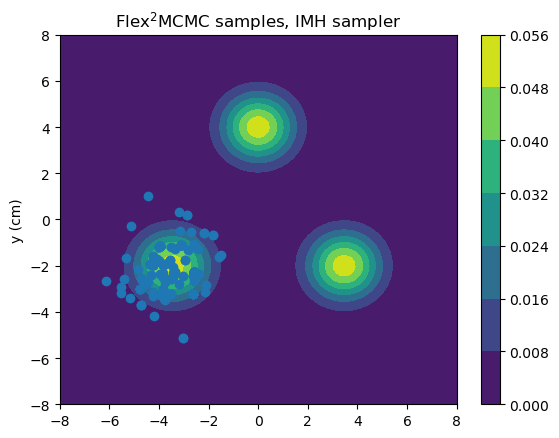

In [10]:
N_pts = 100
part_n = 10
x = np.linspace(-2*a, 2*a, N_pts)
y = np.linspace(-2*a, 2*a, N_pts)
X, Y = np.meshgrid(x, y)
#stack the two
inp = torch.FloatTensor(np.stack([X, Y], -1))
proj_slice = [-2, -1]

#project onto the last 2 coordinates
loc_gaussians = [MNormal(loc[proj_slice], cov[proj_slice, :][:, proj_slice]) for loc, cov in zip(locs, covs)]
log_ps = torch.stack([
    torch.log(weight) + gauss.log_prob(inp.reshape(-1, 2)) for weight, gauss in zip(weights, loc_gaussians)
], dim=0)
dens_vals = torch.logsumexp(log_ps, dim=0).reshape(inp.shape[:-1])
#plot density values
fig,ax=plt.subplots(1,1)
cp = ax.contourf(X, Y, dens_vals.exp())
fig.colorbar(cp) # Add a colorbar to a plot
#plot mala samples
ax.scatter(Samples_flex2_imh[part_n,:,-2],Samples_flex2_imh[part_n,:,-1])
ax.set_title('Flex$^2$MCMC samples, IMH sampler')
#ax.set_xlabel('x (cm)')
ax.set_ylabel('y (cm)')
plt.show()

### Prepare some nice plots

In [ ]:
fig,ax = plt.subplots(1,3,figsize=(15,4))
#select the index of the visualized trajectory
traj_ind = 0
im = ax[0].contourf(X, Y, dens_vals.exp())
im = ax[1].contourf(X, Y, dens_vals.exp())
im = ax[2].contourf(X, Y, dens_vals.exp())
fig.colorbar(im, ax=ax.flat) # Add a colorbar to a plot
#i-sir plots
ax[0].scatter(Samples_isir[traj_ind,:,-2],Samples_isir[traj_ind,:,-1])
ax[0].set_title('i-SIR samples')
ax[0].set_xlabel('$x_1$')
ax[0].set_ylabel('$x_2$')
#mala samples
ax[1].scatter(Samples_mala[traj_ind,:,-2],Samples_mala[traj_ind,:,-1])
ax[1].set_title('MALA samples')
ax[1].set_xlabel('$x_1$')
ax[1].set_ylabel('$x_2$')
#flex2-mcmc sample
ax[2].scatter(Samples_flex2[traj_ind,:,-2],Samples_flex2[traj_ind,:,-1])
ax[2].set_title('Flex$^2$MCMC samples')
ax[2].set_xlabel('$x_1$')
ax[2].set_ylabel('$x_2$')
plt.savefig("toy_samples_flex_50d_the_guy_not_to_worry_about.png", format="png", bbox_inches="tight") 
plt.show()

In [ ]:
import torch

fig, axes = plt.subplots(1,3,figsize=(15,4))
N_pts = 100
xlist = np.linspace(-2*a, 2*a, 100)
ylist = np.linspace(-2*a, 2*a, 100)
X, Y = np.meshgrid(xlist, ylist)
points = np.zeros((2,X.shape[0],X.shape[1]),dtype=float)
points[0] = X
points[1] = Y
dens_vals = np.zeros_like(X)
prop_vals = np.zeros_like(X)
for i in range(N_pts):
    for j in range(N_pts):
        dens_vals[i,j] = target_dens(points[:,i,j])
        prop_vals[i,j] = log_dens_isir(points[:,i,j], sigma_isir)

for na, ax in enumerate(axes):
    plt.sca(ax)
    plt.contourf(X, Y, dens_vals, 10, cmap='GnBu')
    plt.axis('off')
    if na > 0:
        plt.contour(X, Y, prop_vals, 10, colors='k', linestyles=':', alpha=0.25)
## to do equal ratio

# plt.title(title)
    
# plt.colorbar()
# plt.plot(xs[:, 0, 0], xs[:, 0, 1], 'o', c='r', alpha=0.25, ms=2.5)
chainss = [Samples_mala, Samples_isir, Samples_ex2]
titles = ['MALA samples', 'i-SIR samples', 'Ex$^2$MCMC samples']
for ax, chains, title in zip(axes, chainss, titles):
    plt.sca(ax)
    plt.title(title)
    xs = torch.tensor(chains, dtype=torch.float)
    posx, invx, countsx = torch.unique_consecutive(xs[:, 0], return_counts=True, return_inverse=True)

    posy, invy, countsy = torch.unique_consecutive(xs[:, 1], return_counts=True, return_inverse=True)

    plt.plot(xs[:, 0], xs[:, 1], '-', c='k', alpha=0.25)
    plt.scatter(posx, posy, marker='o', c='r', alpha=0.5, s=countsx*20)
    plt.scatter(xs[0,0], xs[0,1],  marker='*', c='k', alpha=0.75, s=40)
#plt.show()
plt.savefig('toy_samples_2d_gaus.pdf', format="pdf", bbox_inches="tight")
plt.show()